In [1]:
import h5py
import numpy as np
import random

In [2]:
### Load neighborhood data from tiny_pdb_dir (25 random pdbs)

filename = "/gscratch/scrubbed/wgalvin/clean_clone/protein_holography-pytorch/protein_holography_pytorch/neighborhoods_tiny.hdf5"

max_atoms = 1000
dt = np.dtype([
    ('res_id','S6', (6)), # S5, 5 (old) ; S6, 6 (new with 2ndary structure)
    ('atom_names', 'S4', (max_atoms)),
    ('elements', 'S1', (max_atoms)),
    ('res_ids', 'S6', (max_atoms, 6)), # S5, 5 (old) ; S6, 6 (new with 2ndary structure)
    ('coords', 'f8', (max_atoms, 3)),
    ('SASAs', 'f8', (max_atoms)),
    ('charges', 'f8', (max_atoms)),
])

BACKBONE_ATOMS = [b' N  ', b' CA ', b' C  ', b' O  ']

EMPTY_ID = tuple([b'', b'', b'', b'', b'', b''])

with h5py.File(filename, "r") as f:
    data = np.unique(np.array(f['data'], dtype=dt), axis=0)

In [3]:
def get_res_ids(neighborhood):
    """
    Returns set of unique residue IDs
    found in the res_ids field
    """
    ids = set()
    for item in neighborhood['res_ids']:
        t = tuple(item)
        if t == EMPTY_ID: break
        ids.add(t)
    return ids


def sample_ids(ids, p):
    """
    Samples p proportion of list
    
    """
    ids = list(ids)
    random.shuffle(ids)
    return set(ids[: int(p * len(ids))])

def get_mask(res_ids, atom_names, ids):
    """
    Returns a boolean mask of size (max_atoms) where
    m[i] is True if corresponding res_id is in the list of 
    res_ids to keep
    """
    
    # no speed up
    # def f(x):
    #     return x in BACKBONE_ATOMS
    # def g(x):
    #     return tuple(x) in ids
    
    # return np.logical_or(
    #    np.array(list(map(lambda x: x in BACKBONE_ATOMS, atom_names))), 
    #    np.array(list(map(lambda x: tuple(x) in ids, res_ids)))
    # )
    
    mask = np.zeros((max_atoms), dtype=bool)
    for i, (res_id, atom_name) in enumerate(zip(res_ids, atom_names)):
        t = tuple(res_id)
        if t == EMPTY_ID: break
        mask[i] = t in ids or atom_name in BACKBONE_ATOMS
    return mask


def pad(arrays, max_atoms):
    """
    Returns LIST of ndarrays padded to max_atoms
    """
    return [pad_arr(arr, max_atoms) for arr in arrays];

def pad_arr(arr, padded_length):
    # get dtype of input array
    dt = arr.dtype

    # shape of sub arrays and first dimension (to be padded)
    shape = arr.shape[1:]
    orig_length = arr.shape[0]

    # check that the padding is large enough to accomdate the data
    if padded_length < orig_length:
        print('Error: Padded length of {}'.format(padded_length),
              'is smaller than original length of array {}'.format(orig_length))

    # create padded array
    padded_shape = (padded_length,*shape)
    mat_arr = np.zeros(padded_shape, dtype=dt)

    # add data to padded array
    mat_arr[:orig_length] = np.array(arr)

    return mat_arr

# @profile
def downsample(neighborhood, p, max_atoms=1000, remove_central=True):
    """
    Takes a neighborhood, removes all but p proportion
    of sidechains.
    
    Leaves backbone atoms in place. 
    
    Returns a copy of the neighborhood modifies
    
    ```
    # USAGE: 
    for neighborhood in data:
        neighborhood = downsample(neighborhood, .5)
        ...
    ```
    """
    
    # all ids
    ids = get_res_ids(neighborhood)
    
    if remove_central:
        ids.remove(tuple(neighborhood['res_id']))
    
    #ids to keep
    ids = sample_ids(ids, p)
    
    mask = get_mask(neighborhood['res_ids'], neighborhood['atom_names'], ids)
    
    info = [neighborhood['res_id'], 
    neighborhood['atom_names'][mask],
    neighborhood['elements'][mask],
    neighborhood['res_ids'][mask],
    neighborhood['coords'][mask],
    neighborhood['SASAs'][mask],
    neighborhood['charges'][mask]]
    
    info[1:] = pad(info[1:], max_atoms)
    
    x = np.zeros(shape=(1), dtype=dt)
    x[0] = (*info, )
    return x[0]


In [9]:
# Very basic benchmarking
from tqdm import tqdm

for n in tqdm(data): downsample(n, .5)

100%|████████████████████████████████████████████████████████████████████████████| 17341/17341 [00:25<00:00, 684.45it/s]


## TODO
sanity checks
- plot in 3d
- pymol?
- make fast -- somehow? And post updated code + timing
    - profile to find bottlenecks? line profiler https://github.com/pyutils/line_profiler
    - Avoid making everything a string -- don't need the pdb name in the res_id? Avoid decoding from bytes?
    - One pass through data

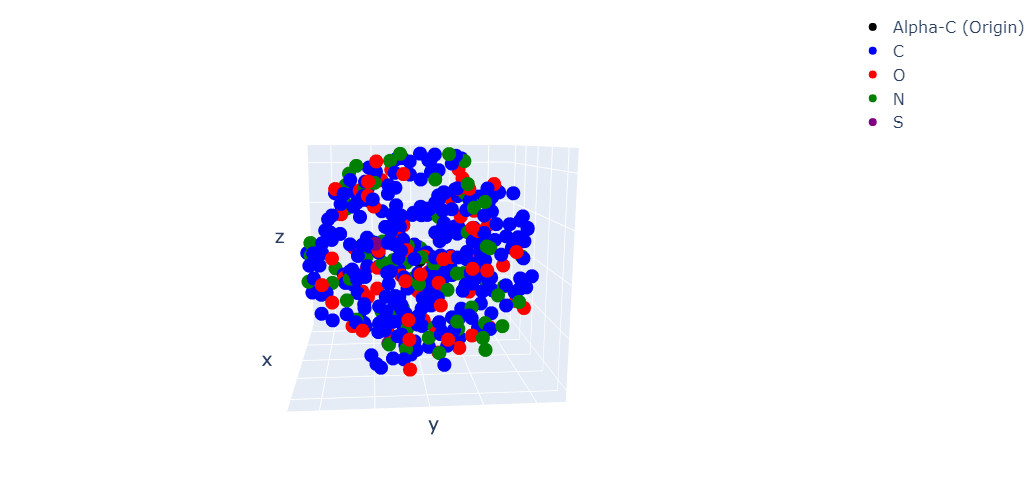

In [4]:
import plotly.graph_objects as go


def extract_coords_by_element(neighborhood):
    coords = neighborhood[4]
    elements = neighborhood[2]
    coords_list = []
    for element in [b'C', b'O', b'N', b'S']:
        coords_list.append(coords[elements == element])
    return coords_list

def plot_neighborhood(neighborhood):
    coords_list = extract_coords_by_element(neighborhood)
    points = []
    origin = [go.Scatter3d(
                x=np.array([0.0]),
                y=np.array([0.0]),
                z=np.array([0.0]),
                mode='markers',
                marker = dict(size=8, color='black'),
                name = 'Alpha-C (Origin)')]
    elements_list = ['C', 'O', 'N', 'S']
    colors_table = {
        'C': 'blue',
        'O': 'red',
        'N': 'green',
        'S': 'purple'
    }
    for element, coords in zip(elements_list, coords_list):
        points.append(go.Scatter3d(
            x=coords[:, 0],
            y=coords[:, 1],
            z=coords[:, 2],
            mode='markers',
            marker = dict(size=8, color=colors_table[element]),
            name = element
            ))
    layout = go.Layout(width=500, height=500,
                       margin=dict(l=0, r=0, t=10, b=0))
    fig = go.Figure(data=[*origin, *points], layout=layout)
    fig.update_layout(font_size=16)
    fig.update_layout(
        scene=dict(
            xaxis=dict(showticklabels=False),
            yaxis=dict(showticklabels=False),
            zaxis=dict(showticklabels=False),
        )
    )
    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=-2.54, y=0.2, z=0.5)
    )
    fig.update_layout(scene_camera=camera)
    fig.show(renderer="jupyterlab")
    
n = data[698]
plot_neighborhood(n)

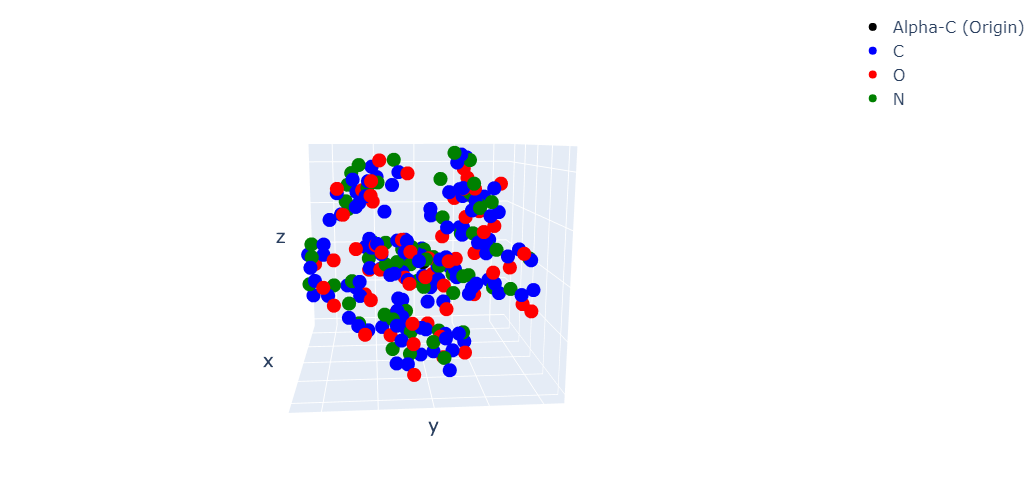

In [7]:
plot_neighborhood(downsample(n, 0))